In [1]:
import sys
import numpy as np
import os
from unet_baseline import CustomCNN
from image_utils import standardize
from IOU_computations import *
from numpy import newaxis
import matplotlib.pyplot as plt
from dataset_generator import DatasetGenerator
from unet_val import UNet

import torch
from unet_baseline_pytorch import predict_pytorch
import torch.backends.cudnn as cudnn

/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [89]:

INPUT_CHANNELS=9
NB_CLASSES=2
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DROPOUT=0.9#0.9

In [90]:
def plot_summary(predictions,labels,pansharp,batch_size,batch_number,prediction_path,display='all'):
    
    if display=='all':
        fig,axs=plt.subplots(3, batch_size,figsize=(8*batch_size,24))

        axs[0,0].set_title(str(batch_number)+' Pansharpened ', fontsize='large')
        axs[1,0].set_title(str(batch_number)+' Groundtruth ', fontsize='large')
        axs[2,0].set_title(str(batch_number)+' Predictions ', fontsize='large')


        for i in range(batch_size):

            axs[0,i].imshow(pansharp[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Pansharpened_'+str(i)+'.jpg',pansharp[i])
            axs[1,i].imshow(labels[i,:,:,0])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Groundtruth_'+str(i)+'.jpg',labels[i,:,:,0])
            logits=np.argmax(predictions, 3)
            axs[2,i].imshow(1-logits[i,:,:])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Predictions_'+str(i)+'.jpg',1-logits[i,:,:])
    
    else:
        fig,axs=plt.subplots(1, batch_size,figsize=(8*batch_size,24))
        axs[0].set_title(str(batch_number)+' Predictions ', fontsize='large')
        for i in range(batch_size):
            logits=np.argmax(predictions, 3)
            axs[i].imshow(1-logits[i,:,:])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Predictions_'+str(i)+'.jpg',1-logits[i,:,:])
        
    plt.subplots_adjust()
    plt.show()



In [91]:
def generate_dataset(path_validation,validation_batch_size):
    val_generator = DatasetGenerator.from_root_folder(path_validation, batch_size=validation_batch_size)
    val_generator=val_generator.shuffled()
    val_generator=val_generator.__iter__()
    return val_generator

In [92]:
def predict_tf(val_generator,number_of_batches,restore_path,prediction_path,display):
    
    TMP_IOU=prediction_path+'TMP_IOU/'
    if not os.path.exists(TMP_IOU):
            os.makedirs(TMP_IOU)
    model=CustomCNN()

    val_generator=val_generator.__iter__()
    for i in range(number_of_batches):
        
        X_val,Y_val=val_generator.__next__()

        predictions=[]
        for j in range(len(X_val)):
            X_val_j=X_val[j]
            X_val_j=X_val_j[newaxis,:,:,:]
            X_val_j=standardize(X_val_j)
            Y_val_j=Y_val[j]
            Y_val_j=Y_val_j[newaxis,:,:,:]

            predictions_i,loss_i=model.predict(restore_path, X_val_j)
            iou_acc_v,f1_v,iou_v=predict_score_batch(TMP_IOU,Y_val_j[:,:,:,0],1-np.argmax(predictions_i,3))
#             print("Image {:d}, Validation IoU {:.4f}, Validation IoU_acc {:.4f}%,Validation F1 IoU {:.4f}%, loss {:.8f}".format(j,iou_v,iou_acc_v,f1_v,loss_i))
            predictions.append(predictions_i)
        predictions=np.squeeze(np.asarray(predictions))
        X_val=standardize(X_val)
        pansharp=np.stack((X_val[:,:,:,5],X_val[:,:,:,3],X_val[:,:,:,2]),axis=3)
        plot_summary(predictions,Y_val,pansharp,len(X_val),i,prediction_path,display)
        

In [93]:
def predict_pytorch_val(val_generator,number_of_batches,restore_path,prediction_path,display):
    TMP_IOU=prediction_path+'TMP_IOU/'
    if not os.path.exists(TMP_IOU):
            os.makedirs(TMP_IOU)
            


    model=UNet(INPUT_CHANNELS,NB_CLASSES,DEFAULT_LAYERS,DEFAULT_FEATURES_ROOT,DROPOUT)
    model.cuda()
    cudnn.benchmark = True
    model.load_state_dict(torch.load(restore_path))
    
    val_generator=val_generator.__iter__()
    
    for i in range(number_of_batches):
        X_val,Y_val=val_generator.__next__()

        predictions=[]
        for j in range(len(X_val)):
            X_val_j=X_val[j]
            X_val_j=X_val_j[newaxis,:,:,:]
            X_val_j=standardize(X_val_j)
            Y_val_j=Y_val[j]
            Y_val_j=Y_val_j[newaxis,:,:,:]

            predictions_i,loss_i=predict_pytorch(model,X_val_j,Y_val_j)
            iou_acc_v,f1_v,iou_v=predict_score_batch(TMP_IOU,Y_val_j[:,:,:,0],1-np.argmax(predictions_i,3))
#             print("Image {:d}, Validation IoU {:.4f}, Validation IoU_acc {:.4f}%,Validation F1 IoU {:.4f}%, loss {:.8f}".format(j,iou_v,iou_acc_v,f1_v,loss_i))
            predictions.append(predictions_i)
            
        predictions=np.squeeze(np.asarray(predictions))
        X_val=standardize(X_val)
        pansharp=np.stack((X_val[:,:,:,5],X_val[:,:,:,3],X_val[:,:,:,2]),axis=3)
        plot_summary(predictions,Y_val,pansharp,len(X_val),i,prediction_path,display)
            
        
        

PYTORCH


/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


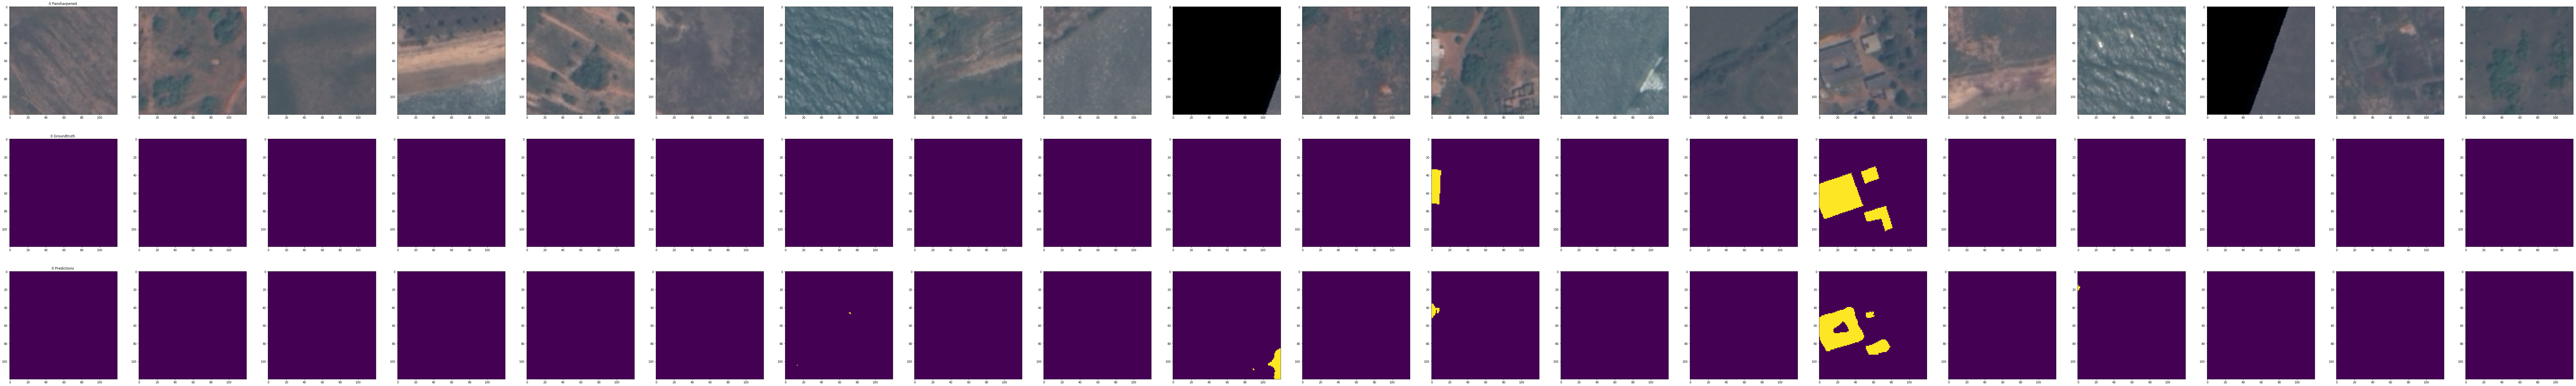

TF BS 8


2018-04-05 14:03:40,307 Layers 4, features 32, filter size 3x3, pool size: 2x2


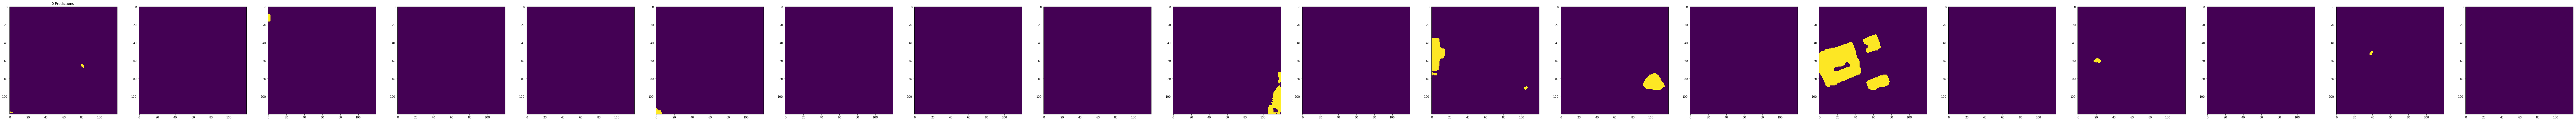

2018-04-05 14:03:58,614 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 16


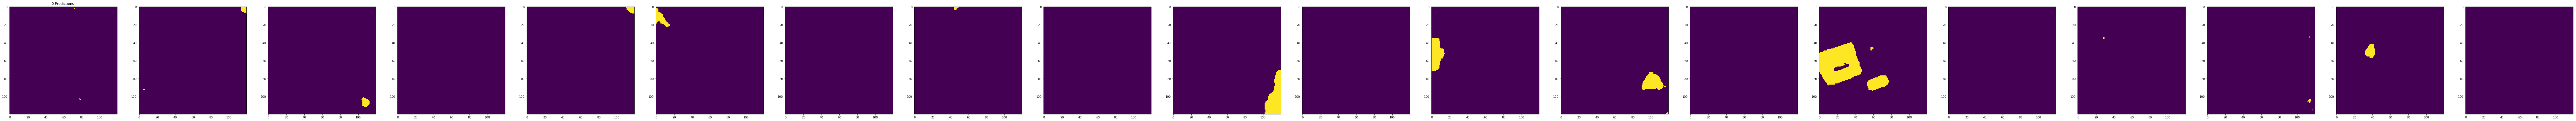

2018-04-05 14:04:14,491 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 32


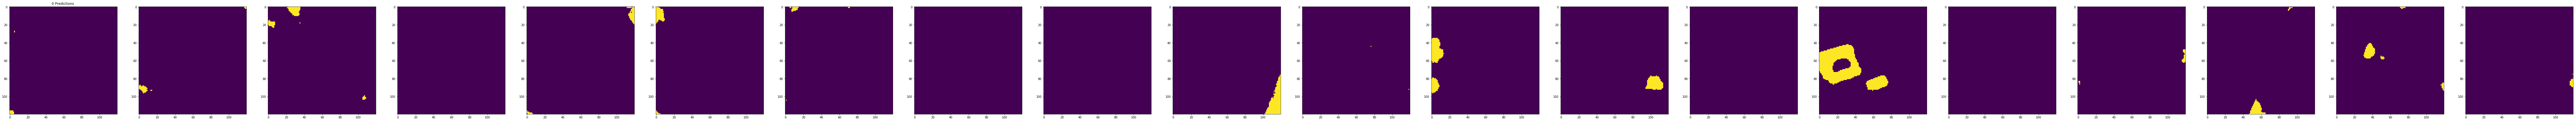

2018-04-05 14:04:29,987 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 64


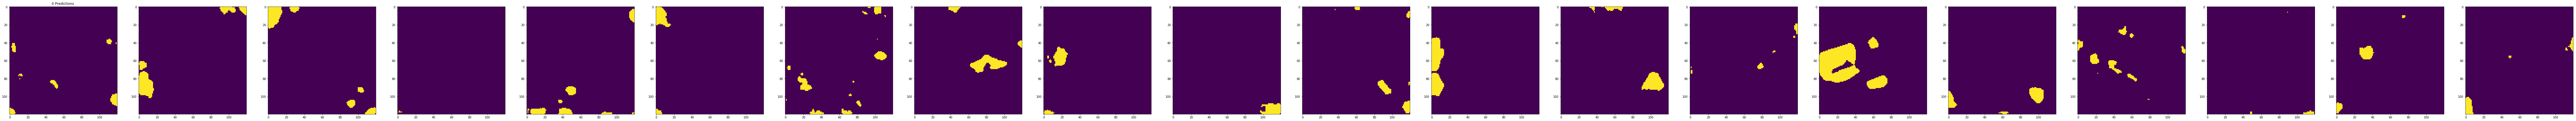

PYTORCH


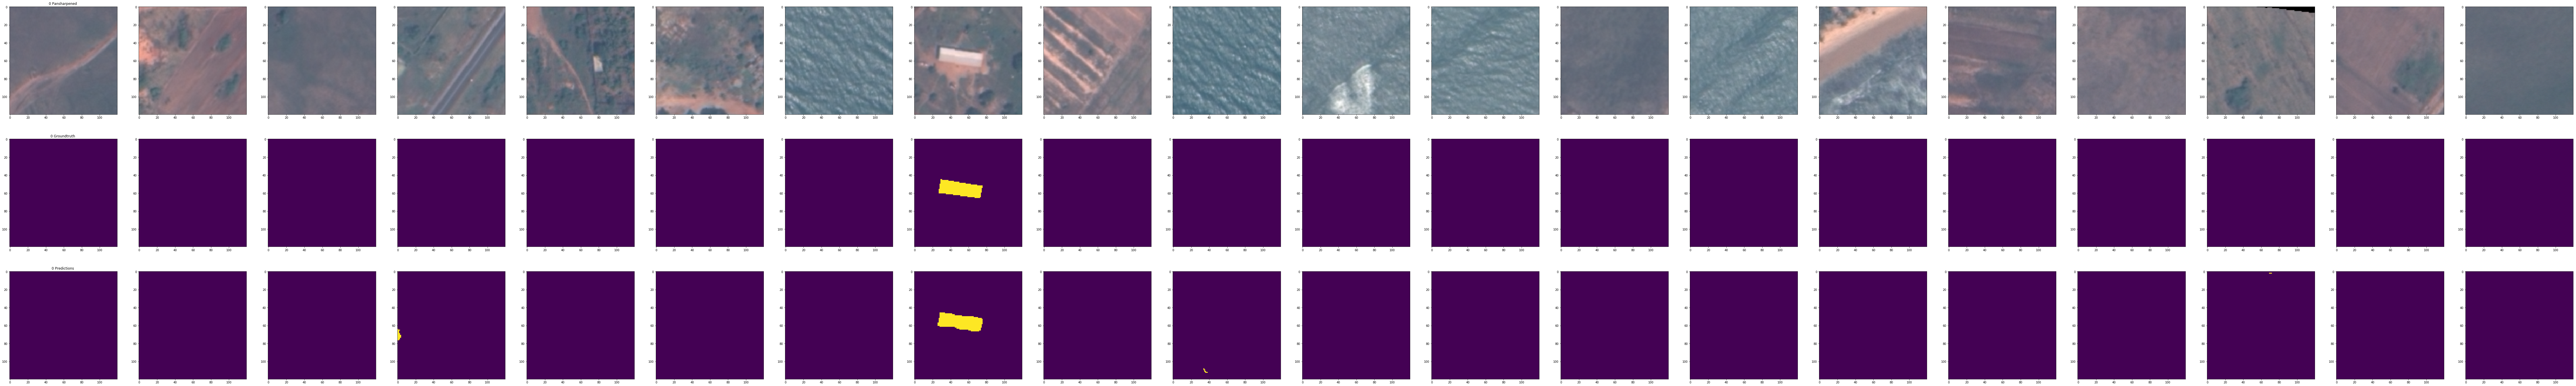

2018-04-05 14:04:55,647 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 8


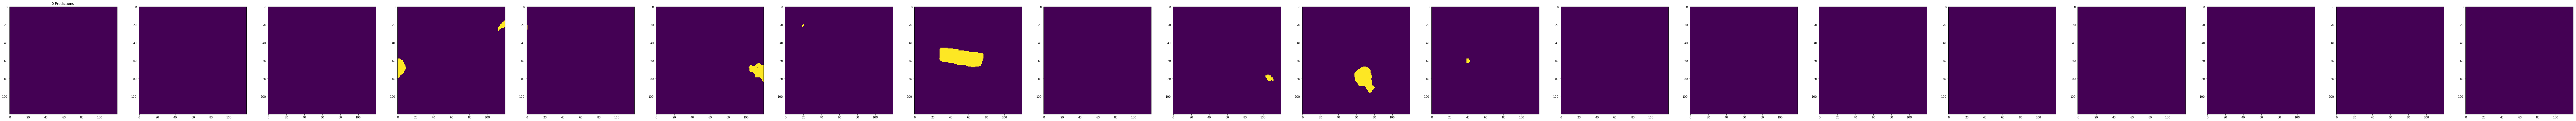

2018-04-05 14:05:11,654 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 16


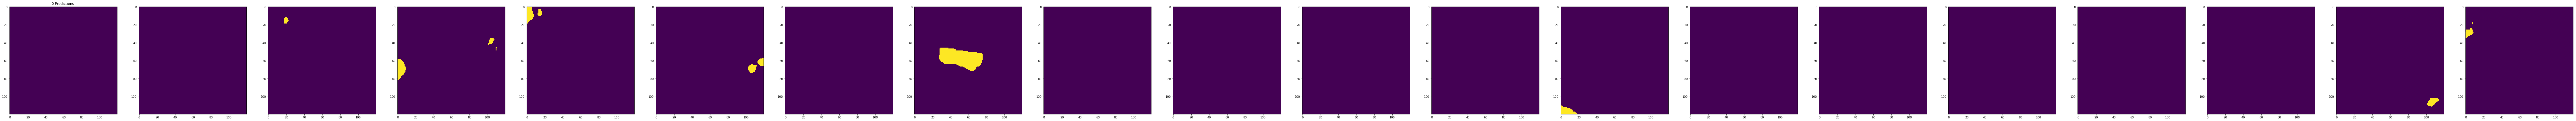

2018-04-05 14:05:27,670 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 32


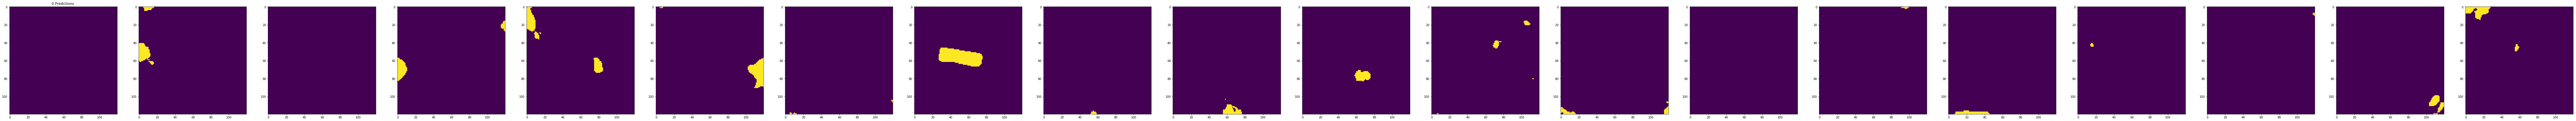

2018-04-05 14:05:43,572 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 64


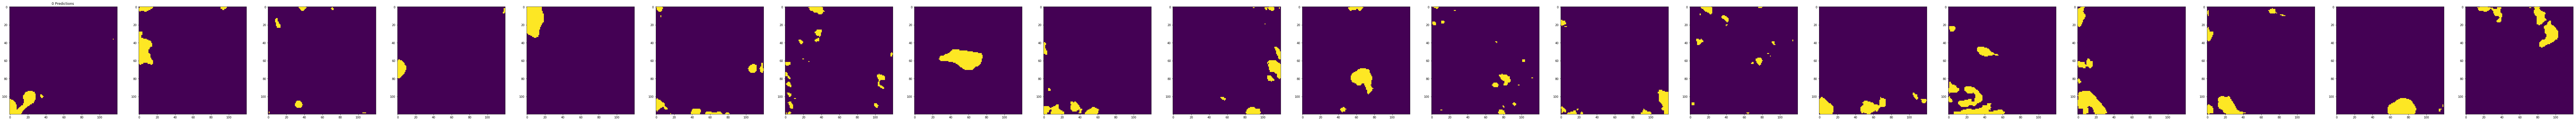

PYTORCH


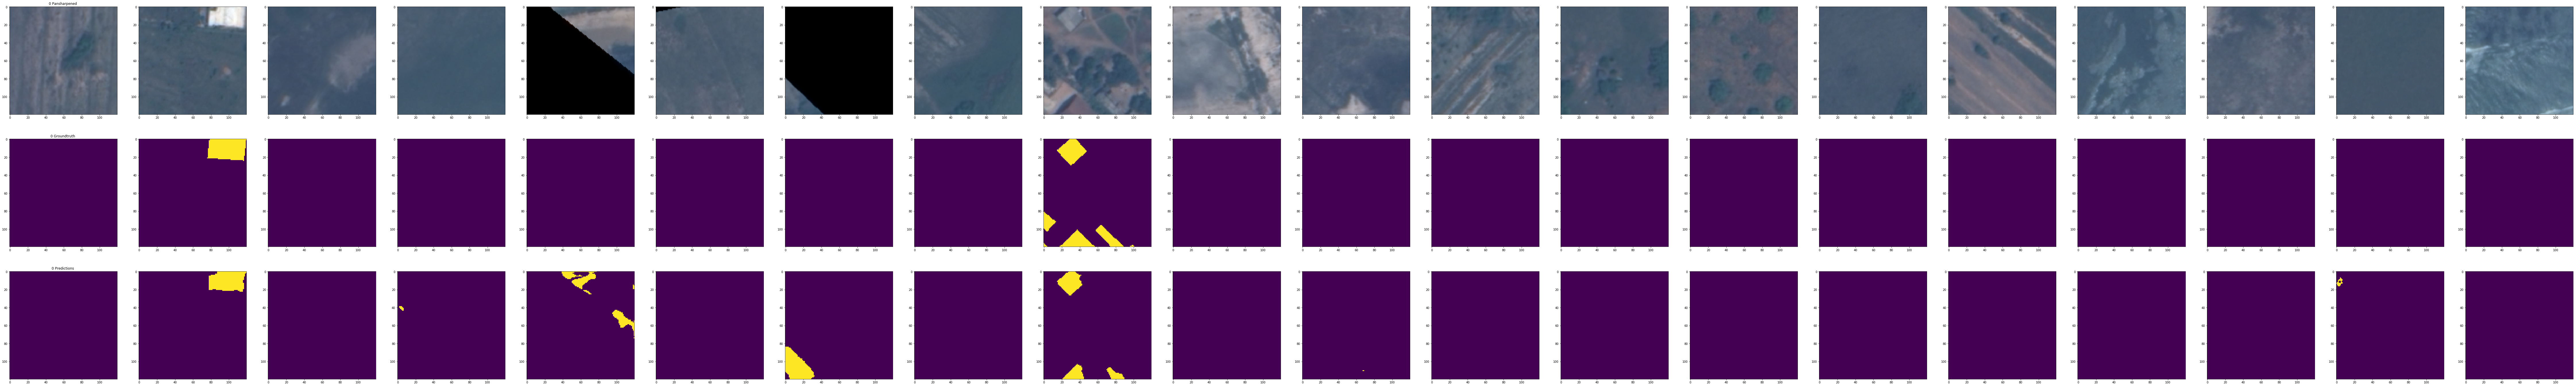

2018-04-05 14:06:09,493 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 8


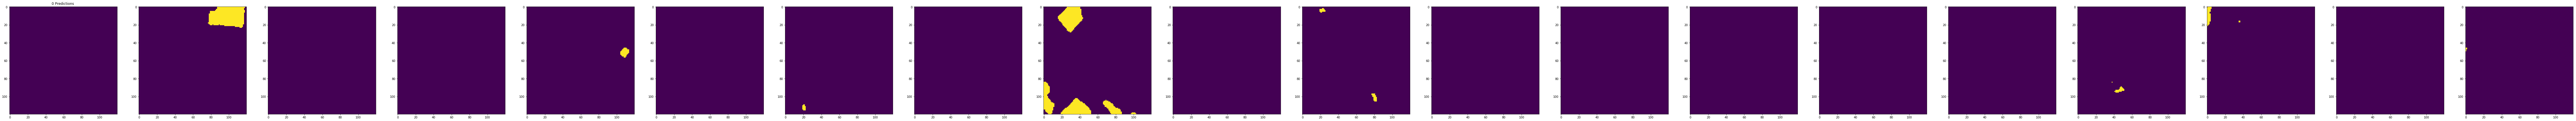

2018-04-05 14:06:25,593 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 16


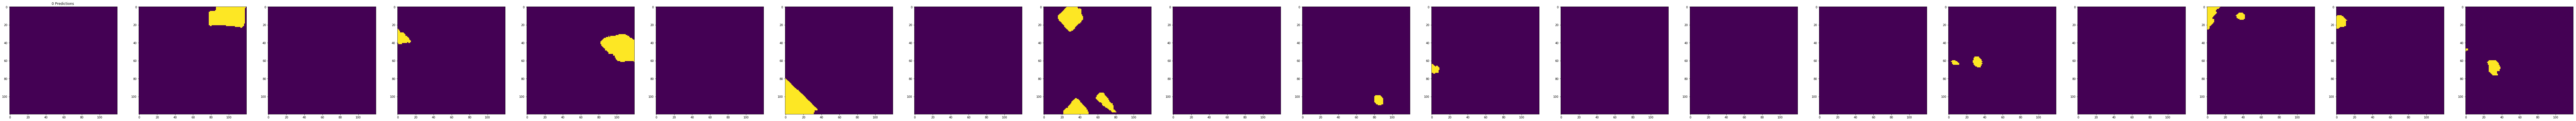

2018-04-05 14:06:42,522 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 32


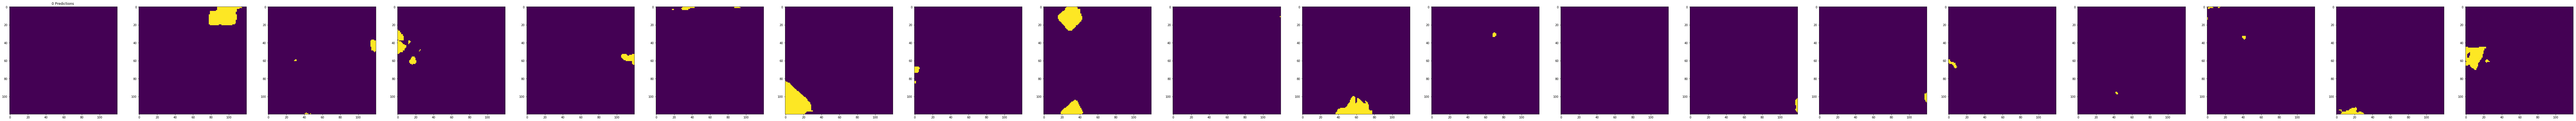

2018-04-05 14:06:58,358 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 64


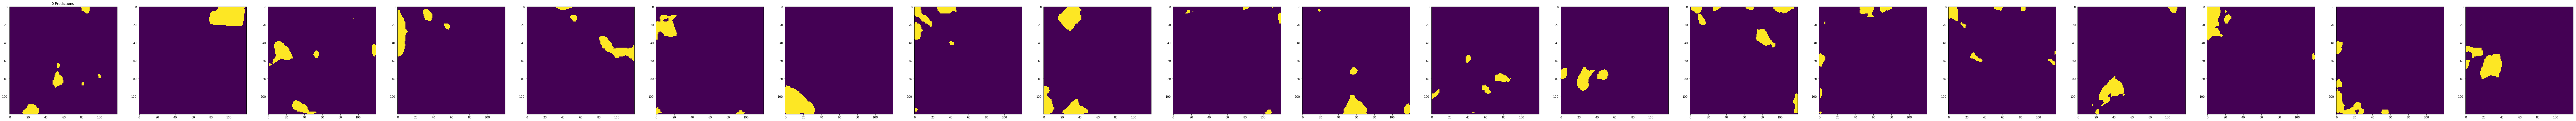

PYTORCH


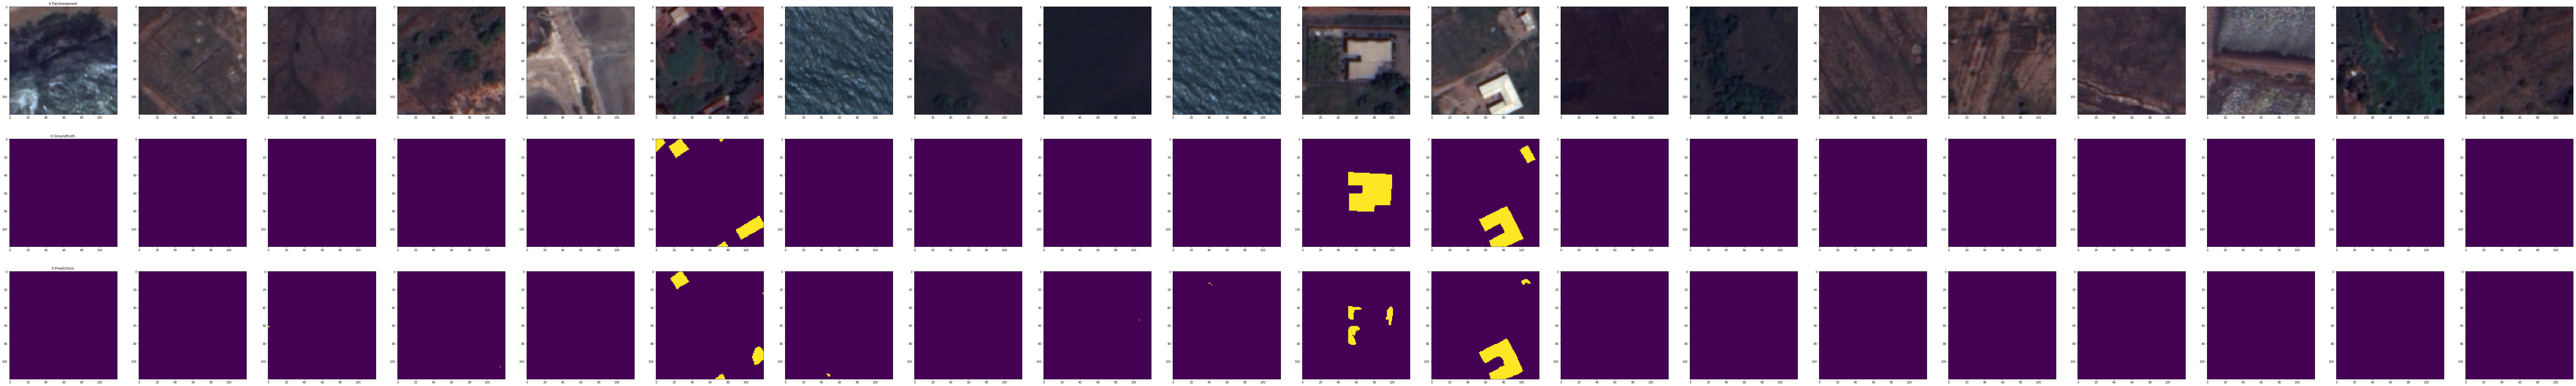

2018-04-05 14:07:25,133 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 8


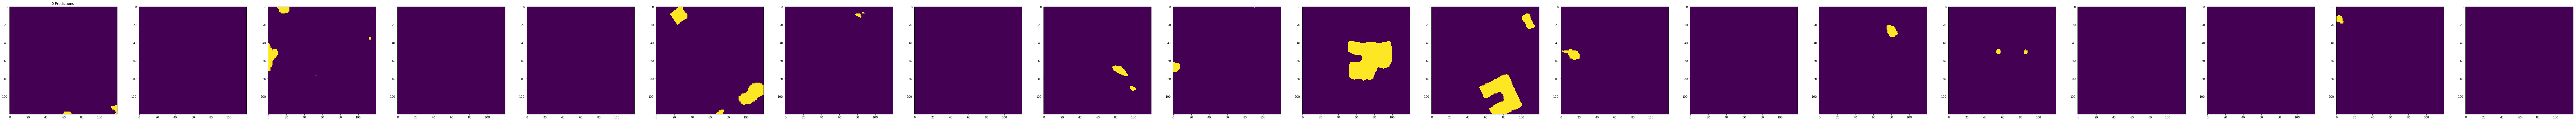

2018-04-05 14:07:41,154 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 16


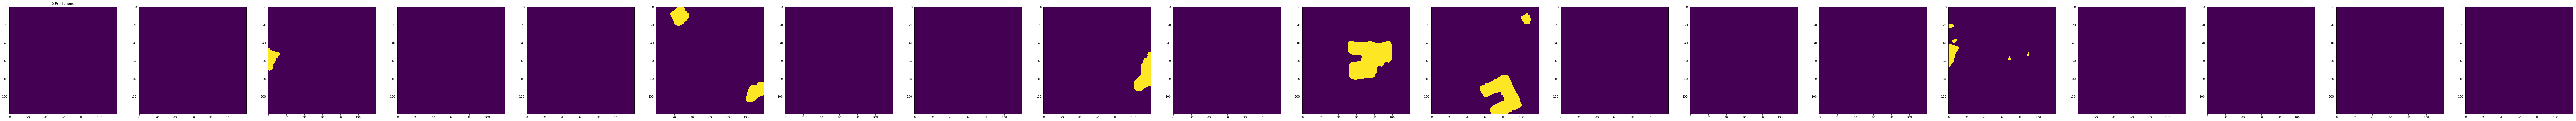

2018-04-05 14:07:57,016 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 32


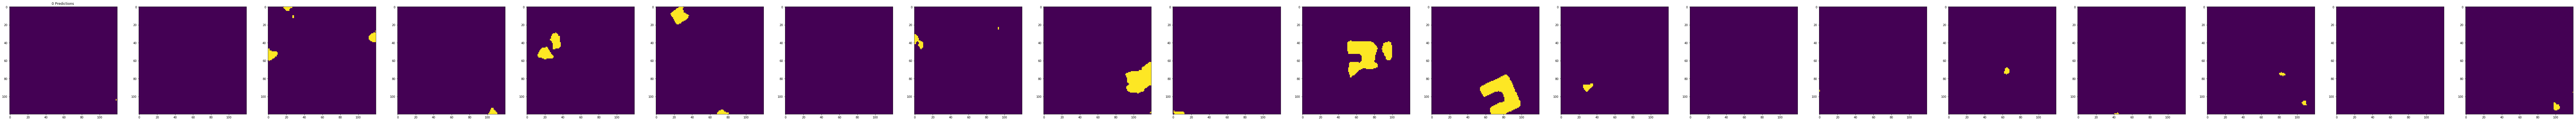

2018-04-05 14:08:12,909 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 64


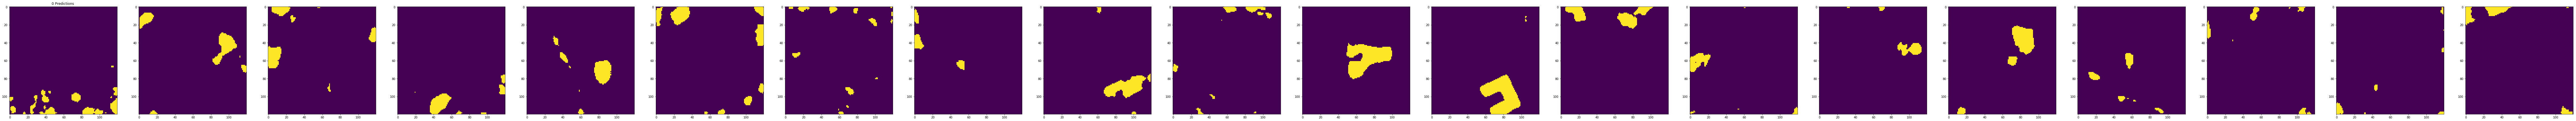

PYTORCH


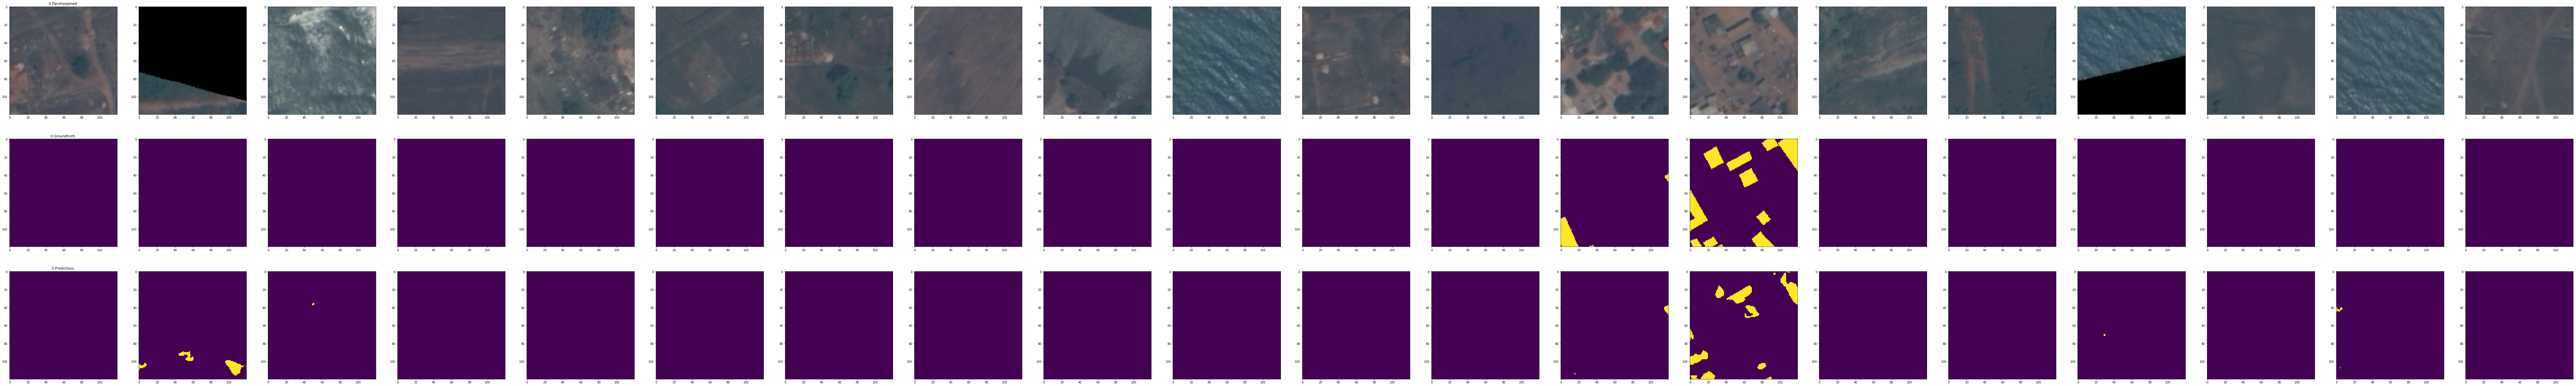

2018-04-05 14:08:39,917 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 8


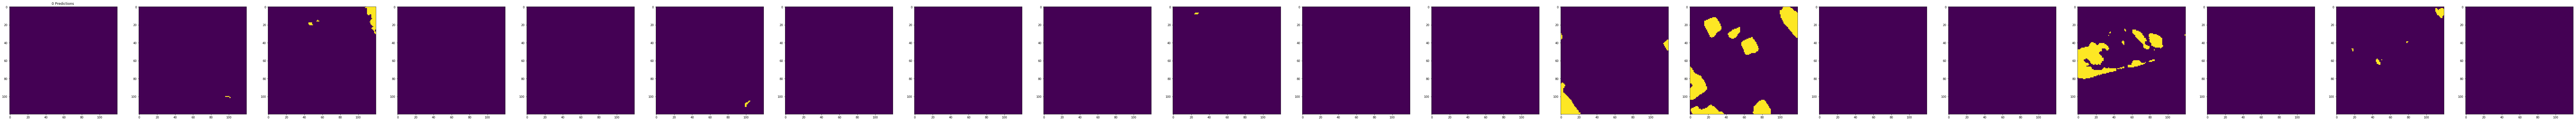

2018-04-05 14:08:56,395 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 16


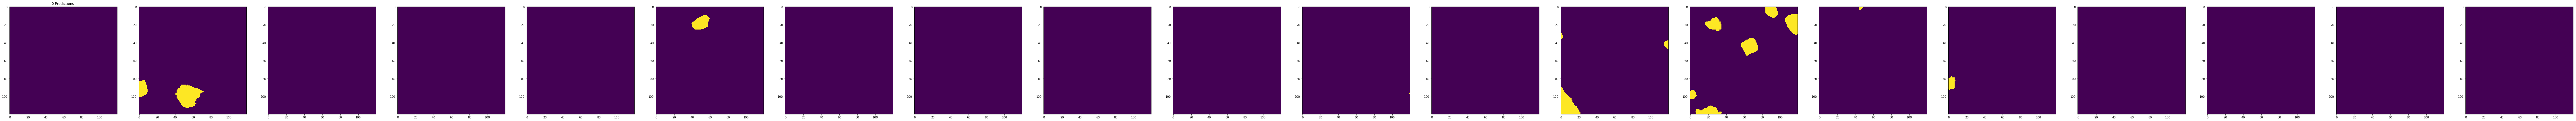

2018-04-05 14:09:12,732 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 32


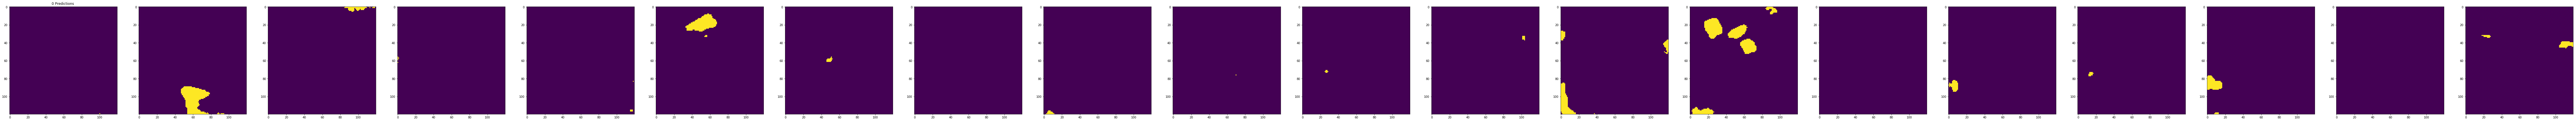

2018-04-05 14:09:28,682 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 64


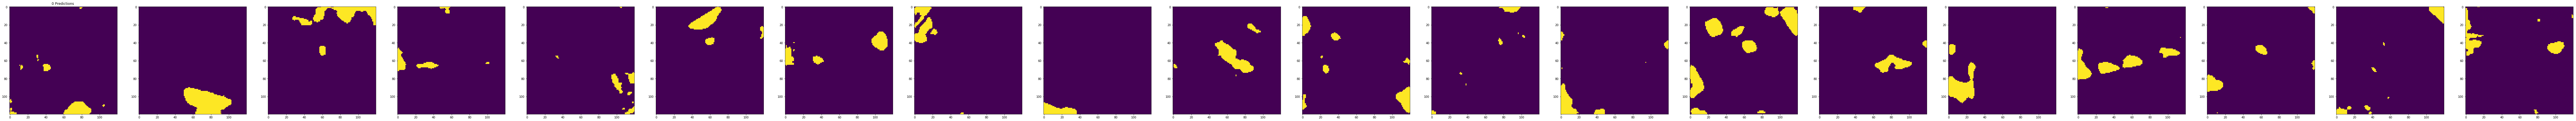

PYTORCH


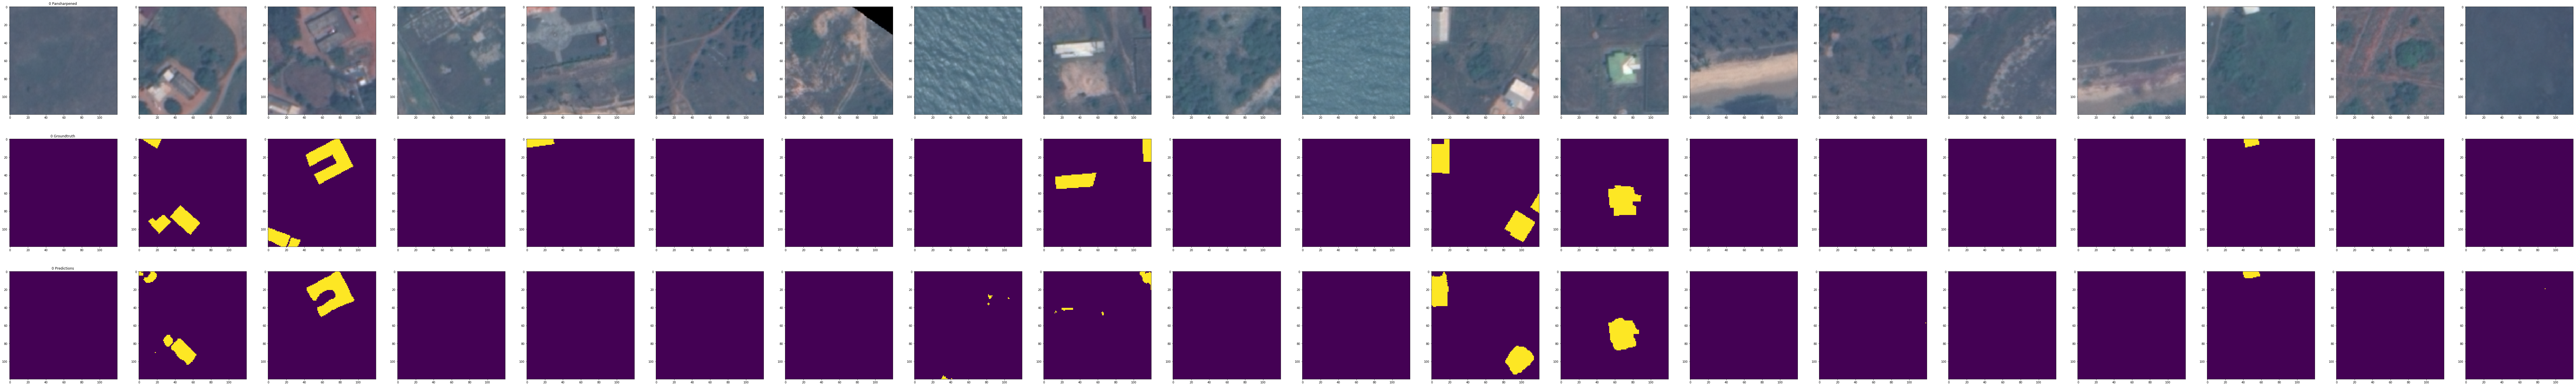

2018-04-05 14:09:54,964 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 8


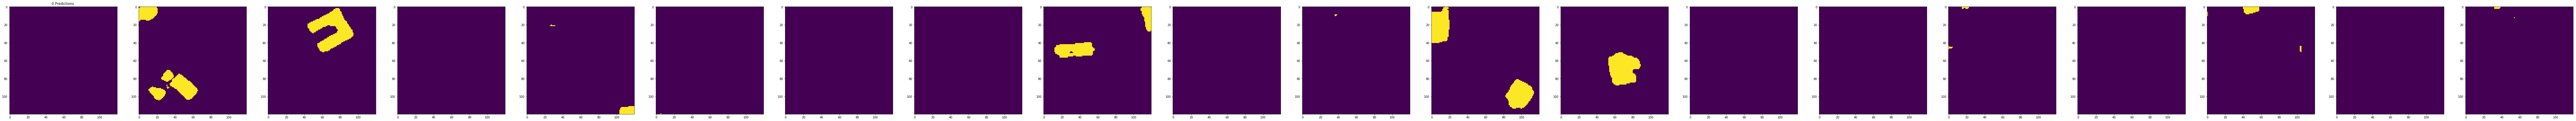

2018-04-05 14:10:10,919 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 16


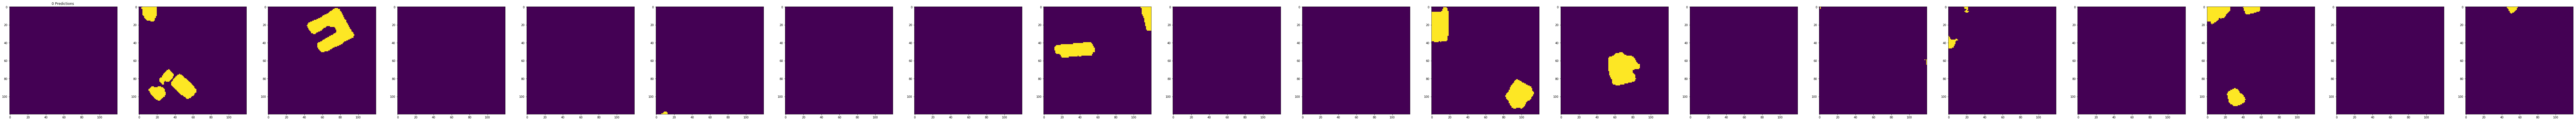

2018-04-05 14:10:26,794 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 32


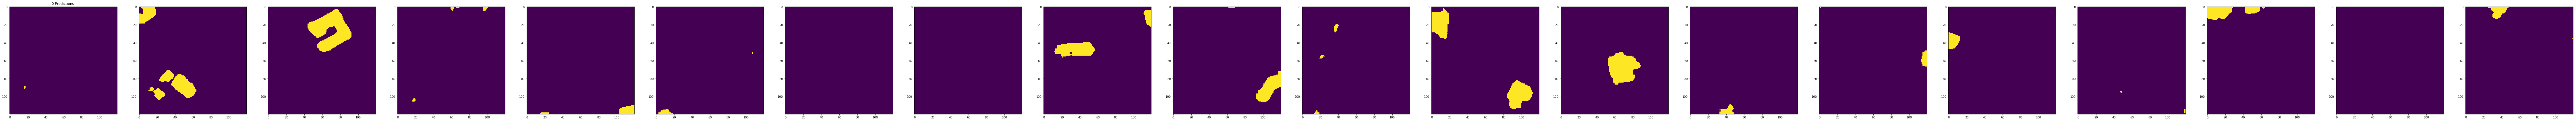

2018-04-05 14:10:42,831 Layers 4, features 32, filter size 3x3, pool size: 2x2


TF BS 64


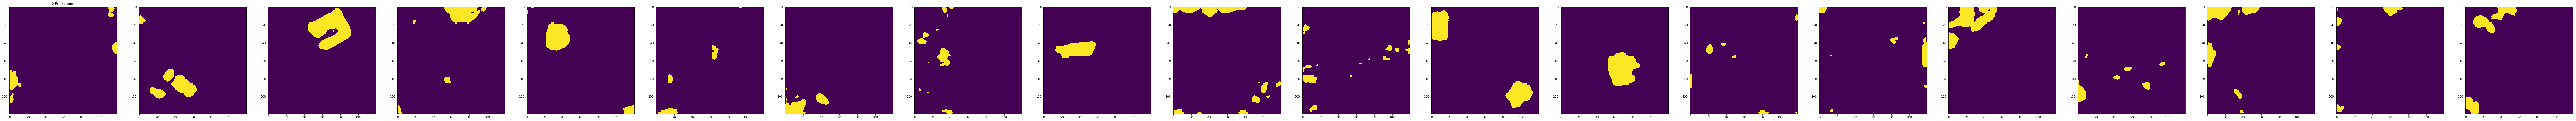

In [94]:
if __name__ == '__main__':
    
    
    
    root_folder = '../DATA_GHANA/DATASET/120_x_120_8_bands/'
    
    
    for i in range(6):
        validation_generator=generate_dataset(root_folder+'TEST/',20)
        #####PYTORCH#########
    
        prediction_path='VISUALIZATION_IMAGES/PYTORCH_VAL_GHANA/'

        if not os.path.exists(prediction_path):
                os.makedirs(prediction_path)


        print('PYTORCH')
        predict_pytorch_val(validation_generator,1,'MODEL_BASIC_TEST_pytorch_120/RESUNET_pytorch_ghanaCP148500.pth',prediction_path,'all')

        #####TF 8 BS#########

        prediction_path='VISUALIZATION_IMAGES/TENSORFLOW_MELI_GHANA_BS8/'

        if not os.path.exists(prediction_path):
                os.makedirs(prediction_path)


        print('TF BS 8')
        predict_tf(validation_generator,1,'MODEL_pansh_8_bs_8/resunet_pansh_8_bs_8.ckpt-148500',prediction_path,'pred')

        #####TF 16 BS#########
        prediction_path='VISUALIZATION_IMAGES/TENSORFLOW_MELI_GHANA_BS16/'

        if not os.path.exists(prediction_path):
                os.makedirs(prediction_path)


        print('TF BS 16')
        predict_tf(validation_generator,1,'MODEL_pansh_8_bs_16/resunet_pansh_8_bs_16_restored.ckpt-49440',prediction_path,'pred')

        #####TF 32 BS#########
        prediction_path='VISUALIZATION_IMAGES/TENSORFLOW_MELI_GHANA_BS32/'

        if not os.path.exists(prediction_path):
                os.makedirs(prediction_path)


        print('TF BS 32')
        predict_tf(validation_generator,1,'MODEL_pansh_8_bs_32/resunet_pansh_8_bs_32_restored_2.ckpt-24640',prediction_path,'pred')


        #####TF 64 BS#########
        prediction_path='VISUALIZATION_IMAGES/TENSORFLOW_MELI_GHANA_BS64/'

        if not os.path.exists(prediction_path):
                os.makedirs(prediction_path)


        print('TF BS 64')
        predict_tf(validation_generator,1,'MODEL_panchro_pansharp_8/RESUNET_panchro_pansharp_8_restored_2.ckpt-12320',prediction_path,'pred')
    

    